In [1]:
!kaggle datasets download gti-upm/leapgestrecog

100%|█████████████████████████████████████▉| 2.13G/2.13G [03:54<00:00, 11.7MB/s]
100%|██████████████████████████████████████| 2.13G/2.13G [03:54<00:00, 9.75MB/s]


In [ ]:
!unzip -q leapgestrecog.zip

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
import os
import random
import cv2
from sklearn.model_selection import train_test_split

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      logical_gpus = tf.config.experimental.list_logical_devices('GPU')
      print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
LABELS = ['01_palm', '02_l','03_fist','04_fist_moved','05_thumb',
          '06_index','07_ok','08_palm_moved','09_c','10_down']

In [3]:
IMAGE_SIZE = 64


def read_images():
  images = []
  labels = []
  count = 0
  for subject in glob('./leapGestRecog/*'):
    for i, label in enumerate(LABELS):
      p = os.path.join(subject, label, '*')
      for imagePath in glob(p):
        image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        images.append(image)
        labels.append(i)
        count += 1
        print('\rnumber of images: ', count, end='')
  print()
  return np.array(images), np.array(labels)

images, labels = read_images()
print(images.shape)
print(labels.shape)

number of images:  20000
(20000, 64, 64)
(20000,)


In [4]:
def shuffle_data(images, labels):
  pairs = [(images[i], labels[i]) for i in range(len(images))]
  random.shuffle(pairs)
  return np.array([p[0] for p in pairs]), np.array([p[1] for p in pairs])


images, labels = shuffle_data(images, labels)

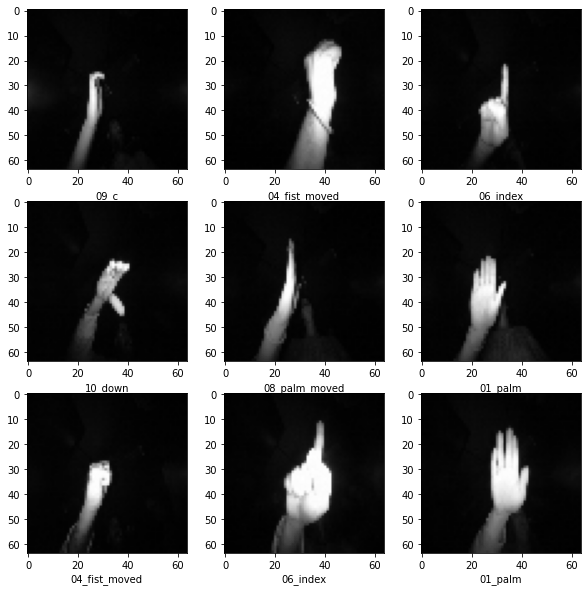

In [5]:
plt.figure(figsize=(10, 10))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(images[i], cmap='gray')
  plt.xlabel(LABELS[labels[i]])
plt.show()

In [6]:
def build_model():
  model =  keras.Sequential([
    keras.layers.Conv2D(16, 3, 2, 'same', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1], activation='relu'),
    keras.layers.Conv2D(16, 3, 1, 'same'),
    keras.layers.Dropout(0.33),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(24, 3, 1, 'same'),
    keras.layers.Dropout(0.33),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
  ])
  optimizer = keras.optimizers.Adam(2.5e-4)
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer, metrics=['accuracy'])
  return model


model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 24)        3480      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 24)        0

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.3, random_state=0)
X_train = np.reshape(X_train, [-1, 64, 64, 1])
X_test = np.reshape(X_test, [-1, 64, 64, 1])
y_train = np.reshape(y_train, [-1, 1])
y_test = np.reshape(y_test, [-1, 1])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14000, 64, 64, 1)
(6000, 64, 64, 1)
(14000, 1)
(6000, 1)


In [8]:
BATCH_SIZE = 64

history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

Epoch 1/30
219/219 [==============================] - 1s 5ms/step - loss: 2.8205 - accuracy: 0.4672 - val_loss: 0.7159 - val_accuracy: 0.8377
Epoch 2/30
219/219 [==============================] - 1s 4ms/step - loss: 0.6202 - accuracy: 0.7971 - val_loss: 0.2117 - val_accuracy: 0.9677
Epoch 3/30
219/219 [==============================] - 1s 5ms/step - loss: 0.2675 - accuracy: 0.9092 - val_loss: 0.0911 - val_accuracy: 0.9855
Epoch 4/30
219/219 [==============================] - 1s 5ms/step - loss: 0.1399 - accuracy: 0.9555 - val_loss: 0.0477 - val_accuracy: 0.9942
Epoch 5/30
219/219 [==============================] - 1s 5ms/step - loss: 0.0805 - accuracy: 0.9714 - val_loss: 0.0336 - val_accuracy: 0.9955
Epoch 6/30
219/219 [==============================] - 1s 5ms/step - loss: 0.0601 - accuracy: 0.9804 - val_loss: 0.0197 - val_accuracy: 0.9968
Epoch 7/30
219/219 [==============================] - 1s 5ms/step - loss: 0.0449 - accuracy: 0.9854 - val_loss: 0.0190 - val_accuracy: 0.9973
Epoch 

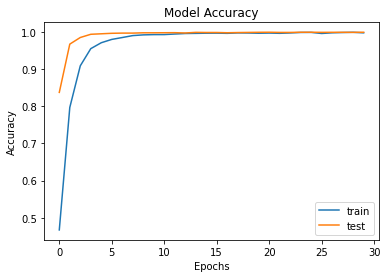

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [10]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

188/188 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 0.9997
Test accuracy: 99.97%


[]

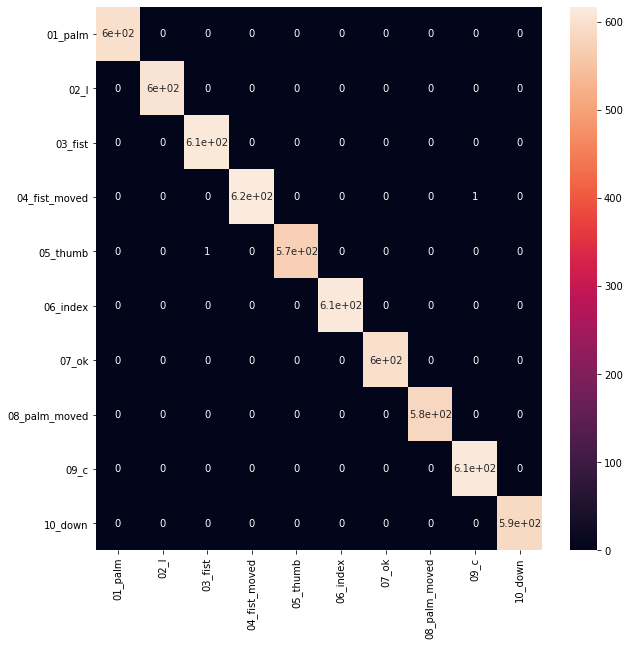

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cat = [c for c in LABELS]
plt.figure(figsize=(10,10))
cm = confusion_matrix(y_test, np.argmax(model.predict(X_test), axis=1))
sn.heatmap(cm, annot=True,xticklabels=cat, yticklabels=cat)
plt.plot()